In [ ]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

Importing data from kaggle:

In [ ]:
! pip install -q kaggle

from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lipinor","key":"585a9766c93956cce87548fe639f6bb8"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c 'titanic'

  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 10.7MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 2.86MB/s]
  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 60.6MB/s]


#Acquiring the Data
Here we get the data we are going to use

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine = [train_df, test_df]

print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


Survived, Sex, and Embarked are categorical features.

Pclass is an ordinal feature.

Age and Fare are continuous numerical features.

SibSp and Parch are discrete numerical features.

In [ ]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

Train data has missing values on Age, Cabin and Embarked classes. Test has missing data on Age, Fare and Cabin classes. We need to find a way to fill in these data with reasonable values.

Let's analyze our data to see what approach we can take. We begin by looking at the correlations of some features with Survived. 

In [ ]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


Here we can see that Pclass is determinant for survival, passengers from upper classes had more chances of surviving. 

In [ ]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


From the table we can conclude that female passengers have a higher survival rate ("*woman and children first*").

In [ ]:
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


The relation between Parch and Survived is not clearly from this data. 

To visualize the relation between the numerical features, we are going to plot a histogram.

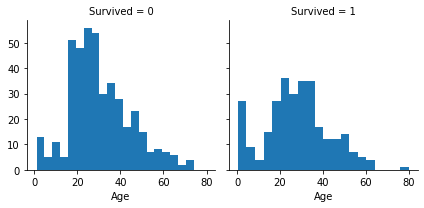

In [ ]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

Note that x-axis in historgram visualizations represents the count of samples or passengers.

Now we plot the number of survivors per Pclass given its Age.

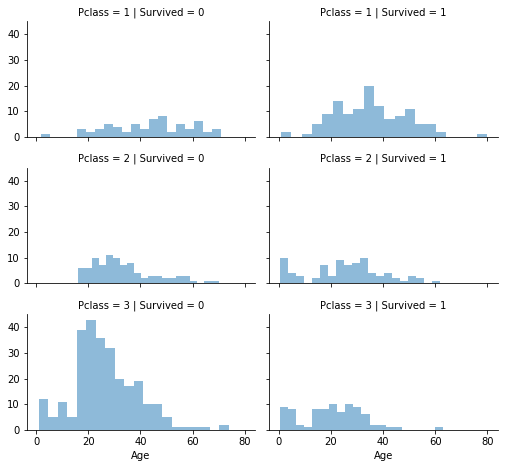

In [ ]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

As expected, the number of victims is higher in the third class.

Let's see if there is any relation between Survived and Embarked.

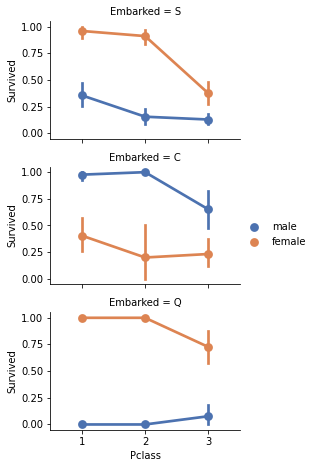

In [ ]:
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

Therefore, Sex is going to be included in the model. 

For now, we are going to do the following:

*   Complete:

1. Age, as it clearly influences survival.
2. Embarked, as only one value is missing.

*   Drop:

1. PassengerID and Name (which does not contributes to survival).
2. Cabin, which has many missing values. We will drop it for now. 

It will also be interesting to create some features based on the given ones:

* Creating:

1. "Family", given by the sum of Parch and Sibling (that is, the family size).
2. "Title", extracted from name (Mr., Mrs., etc).
3. We may want to create new feature for Age bands. 
4. We may also want to create a Fare range feature if it helps our analysis.

Now, let's apply our decisions.


In [ ]:
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

print("After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

Before (891, 12) (418, 11) (891, 12) (418, 11)
After (891, 10) (418, 9) (891, 10) (418, 9)


Now let's extract the titles from the Name feature.

In [ ]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


Many of these titles can be combined into a more common name or be classified as Rare.

In [ ]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


Notice that this reiforces our hypothesis that woman have higher survival rate.

It is good to transform this categorical titles to ordinal:

In [ ]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


Now we can drop the Name and PassengerId features from the training and test datasets.

In [ ]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

Now we are going to convert features that contain strings into numerical values, in order to pipeline it to our neural network.

In [ ]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


Here we fill the Age feature with guessed values.

In [ ]:
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

In [ ]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


It is a good idea to replance "Age" by an "Age Band" feature:

In [ ]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


Looks like older people are less likely to survive.

In [ ]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1,"(32.0, 48.0]"


In [ ]:
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


Her we create the new feature called "FamilySize", as mentioned previously.

In [ ]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


There is some correlation between FamilySize and Survived that cannot be ignored.

But it is a better idea to create a feature "IsAlone".

In [ ]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


So we can drop the other features.

In [ ]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


We also need to complete the Embarked feature. As only two values are missing, let's complete them with the most frequent class:

In [ ]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [ ]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


Let's also convert it to numeric.

In [ ]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,0,1,0
1,1,1,1,2,71.2833,1,3,0
2,1,3,1,1,7.9250,0,2,1
3,1,1,1,2,53.1000,0,3,0
4,0,3,0,2,8.0500,0,1,1


We will do with the feature Fare the same we did with Age:

In [ ]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,0,0,1,0
1,1,1,1,2,3,1,3,0
2,1,3,1,1,1,0,2,1
3,1,1,1,2,3,0,3,0
4,0,3,0,2,1,0,1,1
5,0,3,0,1,1,2,1,1
6,0,1,0,3,3,0,1,1
7,0,3,0,0,2,0,4,0
8,1,3,1,1,1,0,3,0
9,1,2,1,0,2,1,3,0


Now our dataset is all set to be pipelined into a neural network.

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras.layers import Dropout
from keras.optimizers import SGD

from sklearn.model_selection import train_test_split

In [ ]:
X = train_df.to_numpy()[:,1:8] 
Y = train_df.to_numpy()[:,0]
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = seed)
print (f'Shape of Train Data : {X_train.shape}')
print (f'Shape of Test Data : {X_test.shape}')

Shape of Train Data : (712, 7)
Shape of Test Data : (179, 7)


In [ ]:
print(Y)

[0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 0 1 1 0 0 0 1
 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0
 1 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0
 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1
 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 1 0
 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1
 1 0 1 0 0 0 0 0 1 1 1 0 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 0
 0 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0
 0 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 1 1
 1 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0
 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 0 1 0 0 1 0 0 1
 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0
 0 0 1 1 0 1 0 0 1 0 0 0 

In [ ]:
model = Sequential([
  Dense(32, activation='relu', input_dim = (7)),
  Dropout(0.5),
  Dense(16, activation='relu'),
  Dropout(0.5),
  Dense(1, activation='sigmoid'),
])

sgd = SGD(lr = 0.01, momentum = 0.9)

model.compile(
  optimizer=sgd,
  loss='binary_crossentropy',
  metrics=['accuracy'],
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                256       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
  X_train, # training data
  y_train, # training targets
  epochs=150,
  batch_size=32, 
  validation_data = (X_test, y_test), 
  verbose = 1
)

Epoch 1/150
23/23 [==============================] - 0s 9ms/step - loss: 0.8041 - accuracy: 0.6067 - val_loss: 0.6368 - val_accuracy: 0.6201
Epoch 2/150
23/23 [==============================] - 0s 2ms/step - loss: 0.6457 - accuracy: 0.6643 - val_loss: 0.5881 - val_accuracy: 0.7374
Epoch 3/150
23/23 [==============================] - 0s 2ms/step - loss: 0.6275 - accuracy: 0.6770 - val_loss: 0.5563 - val_accuracy: 0.7374
Epoch 4/150
23/23 [==============================] - 0s 2ms/step - loss: 0.6027 - accuracy: 0.6924 - val_loss: 0.5441 - val_accuracy: 0.7263
Epoch 5/150
23/23 [==============================] - 0s 2ms/step - loss: 0.5799 - accuracy: 0.7121 - val_loss: 0.5271 - val_accuracy: 0.7374
Epoch 6/150
23/23 [==============================] - 0s 2ms/step - loss: 0.5739 - accuracy: 0.6980 - val_loss: 0.5127 - val_accuracy: 0.7542
Epoch 7/150
23/23 [==============================] - 0s 2ms/step - loss: 0.5787 - accuracy: 0.7500 - val_loss: 0.5053 - val_accuracy: 0.7318
Epoch 8/150
2

In [ ]:
#@title Função para os plots (la_plots(history))
def la_plots(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    #Epochs
    epochs = range(len(val_loss))

    # Plotting loss
    
    COLOR = 'white'
    plt.rcParams['axes.labelcolor'] = COLOR
    plt.rcParams['xtick.color'] = COLOR
    plt.rcParams['ytick.color'] = COLOR
    

    fig1 = plt.figure(figsize=(8,5))
    gs1 = fig1.add_gridspec(1, 1)
    ax1 = fig1.add_subplot(gs1[0, 0])

    ax1.plot(epochs, loss, 'r', label='Training')
    ax1.plot(epochs, val_loss, 'b', label='Validation')
    ax1.set_xlabel('Epochs', size=16)
    ax1.set_ylabel('Loss', size=16)
    #ax1.set_yscale('log')
    ax1.legend()
    plt.show()

    # Plotting accuracy metric

    fig2 = plt.figure(figsize=(8,5))
    gs2 = fig2.add_gridspec(1, 1)
    ax2 = fig2.add_subplot(gs2[0, 0])

    ax2.plot(epochs, accuracy, 'r', label='Training')
    ax2.plot(epochs, val_accuracy, 'b', label='Validation')
    ax2.set_xlabel('Epochs', size=16)
    ax2.set_ylabel('Accuracy', size=16)
    #ax2.set_yscale('log')
    ax2.legend()
    plt.show()

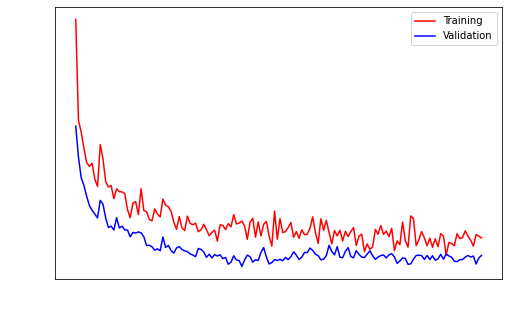

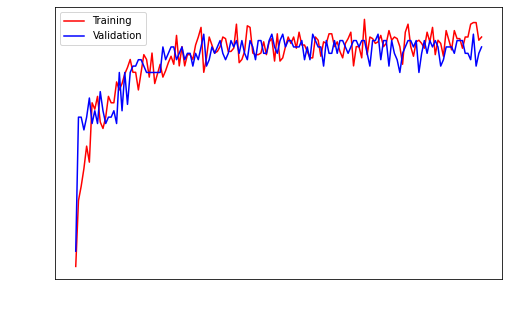

In [ ]:
la_plots(history)

ROC curve:

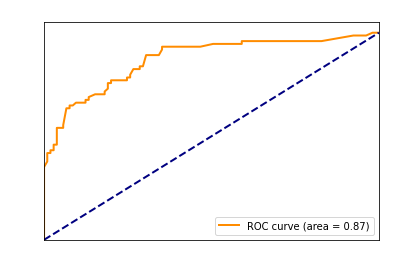

In [ ]:
y_pred  = model.predict(X_test)

from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC',color='white')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

y_final = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_true=y_test, y_pred=y_final)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[94 11]
 [25 49]]


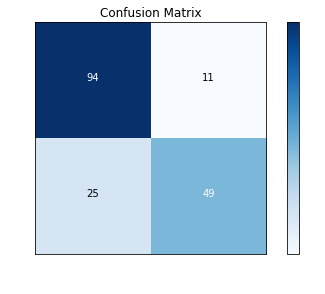

In [ ]:
cm_plot_labels = ['1','0']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Saving the model to submit to kaggle:

In [ ]:
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,892,3,0,2,0,2,1,1
1,893,3,1,2,0,0,3,0
2,894,2,0,3,1,2,1,1
3,895,3,0,1,1,0,1,1
4,896,3,1,1,1,0,3,0


In [ ]:
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,0,0,1,0
1,1,1,1,2,3,1,3,0
2,1,3,1,1,1,0,2,1
3,1,1,1,2,3,0,3,0
4,0,3,0,2,1,0,1,1


In [ ]:
X_pred = test_df.to_numpy()[:,1:8]

predictions = model.predict(X_pred)

pred_final = []

for item in predictions:
  if item>0.5:
    pred_final.append(1)
  else:
    pred_final.append(0)

#pred_final = (y_pred > 0.7).astype(int)

np.size(pred_final)

418

In [ ]:
test_df.PassengerId

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

In [ ]:
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': pred_final})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
